# Notebook 1: Data Exploration & Causal DAG

**Causal Question:** What is the causal impact of smoking on health outcomes (health score, cancer)?

This notebook generates and explores synthetic BRFSS-like data, demonstrates
confounding between treatment groups, and constructs a causal DAG to identify
the backdoor adjustment set needed for unbiased causal estimation.

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import generate_synthetic_brfss, clean_data, engineer_features
from src.utils.config import (
    TREATMENT_COL, OUTCOME_HEALTH, OUTCOME_CANCER,
    COVARIATE_COLS, TRUE_ATE_HEALTH, RANDOM_SEED,
)
from src.utils.dag import CausalDAG
from src.utils.visualization import plot_covariate_distributions

sns.set_style("whitegrid")
print("Setup complete.")

/home/akshay/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Setup complete.


## 1. Data Generation

We generate 10,000 synthetic observations with a known data-generating process.
The true ATE on health score is **-5.0** (smoking reduces health by 5 points).

In [2]:
df_raw = generate_synthetic_brfss(n=10_000)
print(f"Dataset shape: {df_raw.shape}")
print(f"True ATE (health score): {TRUE_ATE_HEALTH}")
df_raw.head()

Dataset shape: (10000, 10)
True ATE (health score): -5.0


,age,female,race,education,income,state_id,urban,smoking,health_score,cancer
0,69.855055,0,black,3,68107.300799,13,1,0,64.805835,0
1,47.404855,0,other,4,17515.120388,2,1,0,77.055530,0
2,75.526061,1,white,6,88238.205081,18,1,0,71.717501,0
3,64.723658,1,white,2,49815.497678,5,1,1,65.101491,0
4,24.309882,1,white,2,27733.325259,0,1,0,72.562058,0


In [3]:
df_raw.describe().round(3)

,age,female,education,income,state_id,urban,smoking,health_score,cancer
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,51.307,0.515,3.810,59009.310,9.515,0.743,0.187,75.772,0.090
std,19.311,0.500,1.294,16658.718,5.768,0.437,0.390,8.598,0.287
min,18.021,0.000,1.000,10000.000,0.000,0.000,0.000,44.134,0.000
25%,34.485,0.000,3.000,47838.323,4.000,0.000,0.000,69.888,0.000
50%,51.386,1.000,4.000,58903.936,10.000,1.000,0.000,75.898,0.000
75%,67.960,1.000,5.000,70384.622,14.000,1.000,0.000,81.863,0.000
max,84.998,1.000,6.000,140019.287,19.000,1.000,1.000,104.180,1.000


## 2. Treatment Distribution

Non-smokers: 8,127  |  Smokers: 1,873
Smoking prevalence: 18.7%


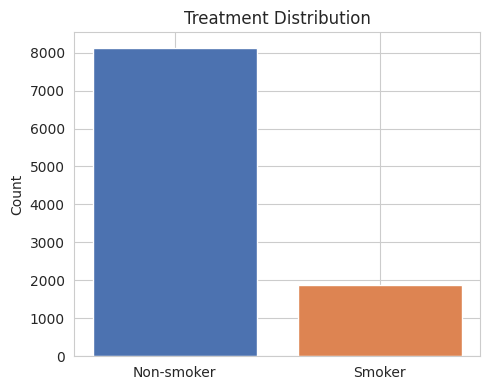

In [4]:
counts = df_raw[TREATMENT_COL].value_counts().sort_index()
print(f"Non-smokers: {counts[0]:,}  |  Smokers: {counts[1]:,}")
print(f"Smoking prevalence: {df_raw[TREATMENT_COL].mean():.1%}")

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(["Non-smoker", "Smoker"], counts.values, color=["#4C72B0", "#DD8452"])
ax.set_ylabel("Count")
ax.set_title("Treatment Distribution")
plt.tight_layout()
plt.show()

## 3. Outcome Distributions

> **Warning:** The naive differences below are **biased by confounding**.

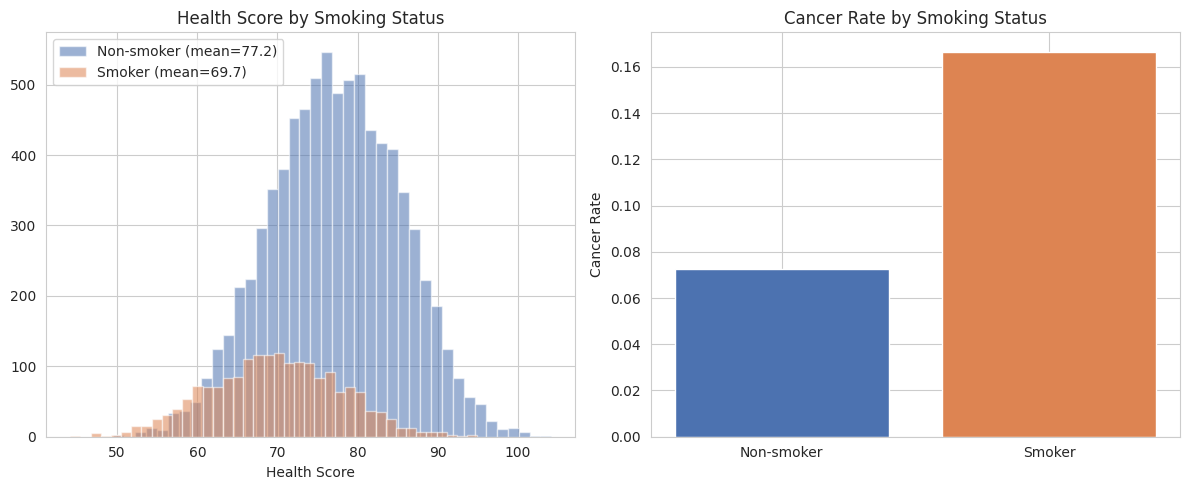

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Health score
for label, color, name in [(0, "#4C72B0", "Non-smoker"), (1, "#DD8452", "Smoker")]:
    subset = df_raw.loc[df_raw[TREATMENT_COL] == label, OUTCOME_HEALTH]
    axes[0].hist(subset, bins=40, alpha=0.55, label=f"{name} (mean={subset.mean():.1f})", color=color)
axes[0].set_xlabel("Health Score")
axes[0].set_title("Health Score by Smoking Status")
axes[0].legend()

# Cancer rate
cancer_rates = df_raw.groupby(TREATMENT_COL)[OUTCOME_CANCER].mean()
axes[1].bar(["Non-smoker", "Smoker"], cancer_rates.values, color=["#4C72B0", "#DD8452"])
axes[1].set_ylabel("Cancer Rate")
axes[1].set_title("Cancer Rate by Smoking Status")

plt.tight_layout()
plt.show()

In [6]:
# Naive mean differences
naive_health = (df_raw.loc[df_raw[TREATMENT_COL]==1, OUTCOME_HEALTH].mean()
                - df_raw.loc[df_raw[TREATMENT_COL]==0, OUTCOME_HEALTH].mean())
print(f"Naive health-score difference: {naive_health:.3f}")
print(f"True ATE:                      {TRUE_ATE_HEALTH}")
print(f"Bias:                          {naive_health - TRUE_ATE_HEALTH:.3f}")
print("\nThe naive estimate is biased because confounders differ between groups.")

Naive health-score difference: -7.464
True ATE:                      -5.0
Bias:                          -2.464

The naive estimate is biased because confounders differ between groups.


## 4. Covariate Exploration

In [7]:
# Numeric covariates by treatment group
numeric_covs = [c for c in ["age", "female", "education", "income", "urban", "state_id"]
                if c in df_raw.columns]
plot_covariate_distributions(df_raw, numeric_covs[:4], TREATMENT_COL, save=False)
plt.show()

In [8]:
# Cross-tab: smoking by education
ct = pd.crosstab(df_raw["education"], df_raw[TREATMENT_COL], margins=True)
ct.columns = ["Non-smoker", "Smoker", "Total"]
print("Smoking prevalence by education level:")
print(df_raw.groupby("education")[TREATMENT_COL].mean().round(3))

Smoking prevalence by education level:
education
1    0.290
2    0.250
3    0.207
4    0.179
5    0.155
6    0.115
Name: smoking, dtype: float64


## 5. Data Cleaning & Feature Engineering

In [9]:
df_clean = clean_data(df_raw)
df = engineer_features(df_clean)
print(f"Shape after cleaning + engineering: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Save processed data
import os
os.makedirs("../data/processed", exist_ok=True)
df.to_csv("../data/processed/cleaned_data.csv", index=False)
print("\nSaved to ../data/processed/cleaned_data.csv")

Shape after cleaning + engineering: (10000, 16)
Columns: ['age', 'female', 'education', 'income', 'state_id', 'urban', 'smoking', 'health_score', 'cancer', 'race_hispanic', 'race_other', 'race_white', 'age_bin', 'income_q', 'age_x_education', 'female_x_education']

Saved to ../data/processed/cleaned_data.csv


## 6. Causal DAG

The DAG encodes our assumptions about the causal structure. Using the
**backdoor criterion**, we identify the variables to condition on for
unbiased estimation of Smoking → HealthScore.

In [10]:
dag = CausalDAG.smoking_health_dag()
dag.plot(save=True)
plt.show()

In [11]:
backdoor = dag.backdoor_variables("Smoking", "HealthScore")
print("Backdoor adjustment set:")
for v in sorted(backdoor):
    print(f"  - {v}")

Backdoor adjustment set:
  - Age
  - Education
  - Gender
  - Income
  - Race


## Summary

1. **Confounding is present** — covariates differ between smokers and non-smokers.
2. **Naive comparisons are biased** — the raw mean difference ≠ true ATE.
3. **The DAG identifies** the variables we must adjust for.
4. **Next:** Notebook 02 applies causal estimators (PSM, IPW, Doubly Robust).